In [46]:
import logging
import os
import sys
import re
import string
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases, ENGLISH_CONNECTOR_WORDS
from gensim.test.utils import datapath
from collections import defaultdict
import multiprocessing

2022-05-20 15:00:51,701 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2022-05-20 15:00:51,701 : INFO : built Dictionary<12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...> from 9 documents (total 29 corpus positions)
2022-05-20 15:00:51,702 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...> from 9 documents (total 29 corpus positions)", 'datetime': '2022-05-20T15:00:51.702254', 'gensim': '4.2.0', 'python': '3.9.7 (default, Sep 16 2021, 13:09:58) \n[GCC 7.5.0]', 'platform': 'Linux-5.15.32-1-MANJARO-x86_64-with-glibc2.35', 'event': 'created'}


In [8]:
TEXT_DATA_DIR = './data/20_newsgroups/'
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
cores = multiprocessing.cpu_count()

In [3]:
# Directory stucture 20_newsgroup/<newsgroup label>/<post ID>

In [4]:
list_results = []
for target in os.listdir(TEXT_DATA_DIR):
    path = os.path.join(TEXT_DATA_DIR, target)
    for text in os.listdir(path):
        file = os.path.join(TEXT_DATA_DIR, target, text)
        with open(file, 'rb') as f:
            list_results.append({'target': target, 'text': f.read()})

In [5]:
df_result = pd.DataFrame(list_results)
df_result.to_csv('./data/20newsgroup_raw.csv', sep=';', index=False)

# Loading the datast

In [ ]:
df = pd.read_csv('./data/20newsgroup_raw.csv', sep=';')

# Preprocessing

In [ ]:
%%time

def clean_header(text):
    text = re.sub(r'(From:\s+[^\n]+\n)', '', text)
    text = re.sub(r'(Subject:[^\n]+\n)', '', text)
    text = re.sub(r'(([\sA-Za-z0-9\-]+)?[A|a]rchive-name:[^\n]+\n)', '', text)
    text = re.sub(r'(Last-modified:[^\n]+\n)', '', text)
    text = re.sub(r'(Version:[^\n]+\n)', '', text)

    return text

df['text_cleaned'] = df['text'].apply(clean_header)

In [ ]:
%%time 

re_url = re.compile(r'(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?')
re_email = re.compile('(?:[a-z0-9!#$%&\'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&\'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9]))\.){3}(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9])|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])')

def clean_text(text):        
    text = text.lower()
    text = text.strip()
    text = re.sub(re_url, '', text)
    text = re.sub(re_email, '', text)
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'(\d+)', ' ', text)
    text = re.sub(r'(\s+)', ' ', text)
#     print(text)
    return text

df['text_cleaned'] = df['text'].apply(clean_text)

In [ ]:
%%time 

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'know', 'make','also','say','take','come','want','look','even','find','thing','problem','need'
                 ,'first','much','many','light','call','last', 'bxref'])
stop_words = set(stop_words)

df['text_cleaned'] = df['text_cleaned'].str.split() \
    .apply(lambda x: ' '.join([word for word in x if word not in stop_words]))

# Saving the cleaned dataset

In [9]:
df.to_csv('./data/20newsgroup_preprocessed.csv', index=False, sep=';')

NameError: name 'df' is not defined

# Load the cleaned dataset

In [12]:
df = pd.read_csv('./data/20newsgroup_preprocessed.csv', sep=';')

In [21]:
df.head()

,target,text,text_cleaned
0,talk.politics.misc,b'Xref: cantaloupe.srv.cs.cmu.edu talk.politic...,cantaloupesrvcscmuedu talkpoliticsmisc altsex ...
1,talk.politics.misc,b'Xref: cantaloupe.srv.cs.cmu.edu alt.politics...,cantaloupesrvcscmuedu altpoliticsclinton talkp...
2,talk.politics.misc,b'Xref: cantaloupe.srv.cs.cmu.edu talk.religio...,cantaloupesrvcscmuedu talkreligionmisc talkpol...
3,talk.politics.misc,b'Xref: cantaloupe.srv.cs.cmu.edu talk.abortio...,cantaloupesrvcscmuedu talkabortion talkreligio...
4,talk.politics.misc,b'Xref: cantaloupe.srv.cs.cmu.edu talk.politic...,cantaloupesrvcscmuedu talkpoliticsmisc altpoli...


In [34]:
df = df.dropna().drop_duplicates()
df.shape

(19992, 3)

In [35]:
sent = [row.split() for row in df['text_cleaned']]

In [36]:
phrases = Phrases(sent, min_count=30, progress_per=1000, ) # connector_words=ENGLISH_CONNECTOR_WORDS

2022-05-20 14:56:30,373 : INFO : collecting all words and their counts
2022-05-20 14:56:30,375 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2022-05-20 14:56:30,587 : INFO : PROGRESS: at sentence #1000, processed 222771 words and 184767 word types
2022-05-20 14:56:30,865 : INFO : PROGRESS: at sentence #2000, processed 491500 words and 358827 word types
2022-05-20 14:56:31,025 : INFO : PROGRESS: at sentence #3000, processed 662429 words and 502308 word types
2022-05-20 14:56:31,171 : INFO : PROGRESS: at sentence #4000, processed 814327 words and 606514 word types
2022-05-20 14:56:31,396 : INFO : PROGRESS: at sentence #5000, processed 1018597 words and 795769 word types
2022-05-20 14:56:31,519 : INFO : PROGRESS: at sentence #6000, processed 1142510 words and 884478 word types
2022-05-20 14:56:31,733 : INFO : PROGRESS: at sentence #7000, processed 1325710 words and 1001656 word types
2022-05-20 14:56:31,888 : INFO : PROGRESS: at sentence #8000, processed 1438622 wo

In [37]:
bigram = Phraser(phrases)

2022-05-20 14:56:36,105 : INFO : exporting phrases from Phrases<2205322 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
2022-05-20 14:56:39,083 : INFO : FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<2401 phrases, min_count=30, threshold=10.0> from Phrases<2205322 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 2.98s', 'datetime': '2022-05-20T14:56:39.083243', 'gensim': '4.2.0', 'python': '3.9.7 (default, Sep 16 2021, 13:09:58) \n[GCC 7.5.0]', 'platform': 'Linux-5.15.32-1-MANJARO-x86_64-with-glibc2.35', 'event': 'created'}


In [39]:
sentences = bigram[sent]

# Most Frequent Words

In [40]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1

len(word_freq)

404289

In [41]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['n', 'one', 'would', 'people', 'nn', 'get', 'dont', 'like', 'think', 'may']

# Training The Word2Vec Model

In [42]:
cores = multiprocessing.cpu_count()

In [43]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

2022-05-20 14:56:48,866 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.03>', 'datetime': '2022-05-20T14:56:48.866653', 'gensim': '4.2.0', 'python': '3.9.7 (default, Sep 16 2021, 13:09:58) \n[GCC 7.5.0]', 'platform': 'Linux-5.15.32-1-MANJARO-x86_64-with-glibc2.35', 'event': 'created'}


In [44]:
%%time

w2v_model.build_vocab(sentences, progress_per=1000)

2022-05-20 14:56:50,025 : INFO : collecting all words and their counts
2022-05-20 14:56:50,027 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-05-20 14:56:50,182 : INFO : PROGRESS: at sentence #1000, processed 208031 words, keeping 40626 word types
2022-05-20 14:56:50,369 : INFO : PROGRESS: at sentence #2000, processed 462743 words, keeping 70904 word types
2022-05-20 14:56:50,491 : INFO : PROGRESS: at sentence #3000, processed 626283 words, keeping 103079 word types
2022-05-20 14:56:50,598 : INFO : PROGRESS: at sentence #4000, processed 771019 words, keeping 123343 word types
2022-05-20 14:56:50,745 : INFO : PROGRESS: at sentence #5000, processed 963410 words, keeping 175281 word types
2022-05-20 14:56:50,836 : INFO : PROGRESS: at sentence #6000, processed 1080483 words, keeping 191385 word types
2022-05-20 14:56:50,969 : INFO : PROGRESS: at sentence #7000, processed 1252459 words, keeping 211340 word types
2022-05-20 14:56:51,056 : INFO : PROGRESS: at 

CPU times: user 2.73 s, sys: 19.8 ms, total: 2.75 s
Wall time: 2.74 s


In [45]:
%%time

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

2022-05-20 14:56:54,252 : INFO : Word2Vec lifecycle event {'msg': 'training model with 11 workers on 16418 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2 shrink_windows=True', 'datetime': '2022-05-20T14:56:54.252657', 'gensim': '4.2.0', 'python': '3.9.7 (default, Sep 16 2021, 13:09:58) \n[GCC 7.5.0]', 'platform': 'Linux-5.15.32-1-MANJARO-x86_64-with-glibc2.35', 'event': 'train'}
2022-05-20 14:56:55,294 : INFO : EPOCH 0 - PROGRESS: at 8.52% examples, 212405 words/s, in_qsize 21, out_qsize 0
2022-05-20 14:56:56,312 : INFO : EPOCH 0 - PROGRESS: at 27.59% examples, 262958 words/s, in_qsize 17, out_qsize 0
2022-05-20 14:56:57,431 : INFO : EPOCH 0 - PROGRESS: at 47.87% examples, 257979 words/s, in_qsize 21, out_qsize 0
2022-05-20 14:56:58,437 : INFO : EPOCH 0 - PROGRESS: at 70.66% examples, 281492 words/s, in_qsize 14, out_qsize 0
2022-05-20 14:56:59,469 : INFO : EPOCH 0 - PROGRESS: at 86.49% examples, 281698 words/s, in_qsize 21, out_qsize 0
2022-05-20 14:56:

2022-05-20 14:57:56,736 : INFO : EPOCH 11 - PROGRESS: at 31.06% examples, 285918 words/s, in_qsize 15, out_qsize 0
2022-05-20 14:57:57,776 : INFO : EPOCH 11 - PROGRESS: at 51.21% examples, 283146 words/s, in_qsize 21, out_qsize 0
2022-05-20 14:57:58,802 : INFO : EPOCH 11 - PROGRESS: at 71.84% examples, 290318 words/s, in_qsize 21, out_qsize 0
2022-05-20 14:57:59,824 : INFO : EPOCH 11 - PROGRESS: at 96.75% examples, 307303 words/s, in_qsize 7, out_qsize 1
2022-05-20 14:57:59,857 : INFO : EPOCH 11: training on 3012996 raw words (1616602 effective words) took 5.2s, 312522 effective words/s
2022-05-20 14:58:00,910 : INFO : EPOCH 12 - PROGRESS: at 9.95% examples, 251111 words/s, in_qsize 21, out_qsize 0
2022-05-20 14:58:01,913 : INFO : EPOCH 12 - PROGRESS: at 27.21% examples, 260202 words/s, in_qsize 21, out_qsize 0
2022-05-20 14:58:02,920 : INFO : EPOCH 12 - PROGRESS: at 49.14% examples, 274429 words/s, in_qsize 16, out_qsize 4
2022-05-20 14:58:03,942 : INFO : EPOCH 12 - PROGRESS: at 69.61

2022-05-20 14:59:03,080 : INFO : EPOCH 23 - PROGRESS: at 69.64% examples, 273612 words/s, in_qsize 21, out_qsize 0
2022-05-20 14:59:04,118 : INFO : EPOCH 23 - PROGRESS: at 91.34% examples, 288197 words/s, in_qsize 19, out_qsize 0
2022-05-20 14:59:04,246 : INFO : EPOCH 23: training on 3012996 raw words (1616874 effective words) took 5.4s, 299345 effective words/s
2022-05-20 14:59:05,309 : INFO : EPOCH 24 - PROGRESS: at 10.66% examples, 262314 words/s, in_qsize 20, out_qsize 1
2022-05-20 14:59:06,326 : INFO : EPOCH 24 - PROGRESS: at 29.77% examples, 272963 words/s, in_qsize 21, out_qsize 0
2022-05-20 14:59:07,359 : INFO : EPOCH 24 - PROGRESS: at 49.78% examples, 273889 words/s, in_qsize 21, out_qsize 0
2022-05-20 14:59:08,473 : INFO : EPOCH 24 - PROGRESS: at 69.50% examples, 273486 words/s, in_qsize 21, out_qsize 0
2022-05-20 14:59:09,513 : INFO : EPOCH 24 - PROGRESS: at 86.00% examples, 278498 words/s, in_qsize 21, out_qsize 0
2022-05-20 14:59:09,761 : INFO : EPOCH 24: training on 30129

CPU times: user 13min 53s, sys: 3.18 s, total: 13min 56s
Wall time: 2min 42s


(48499252, 90389880)

In [47]:
w2v_model.vector_size

300

In [48]:
w2v_model.wv.most_similar('think')

[('believe', 0.5545878410339355),
 ('really', 0.5534641146659851),
 ('dont', 0.5420151352882385),
 ('would', 0.5242295861244202),
 ('thats', 0.5077286958694458),
 ('see', 0.4936996400356293),
 ('one', 0.49160706996917725),
 ('dont_think', 0.49148738384246826),
 ('well', 0.4877195656299591),
 ('still', 0.4821632504463196)]

In [52]:
w2v_model.wv.most_similar(positive=['second', 'third'])

[('fourth', 0.41071438789367676),
 ('ninth', 0.39454782009124756),
 ('one', 0.38153037428855896),
 ('entryway', 0.37025541067123413),
 ('sixth', 0.36710095405578613),
 ('thensecond', 0.3544292747974396),
 ('came_back', 0.3525027632713318),
 ('inning', 0.3333137631416321),
 ('nthe', 0.32803401350975037),
 ('paragraphnnthe', 0.32782208919525146)]

In [53]:
for index, word in enumerate(w2v_model.wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(w2v_model.wv.index_to_key)} is {word}")

word #0/16418 is n
word #1/16418 is one
word #2/16418 is would
word #3/16418 is people
word #4/16418 is nn
word #5/16418 is get
word #6/16418 is dont
word #7/16418 is like
word #8/16418 is think
word #9/16418 is may


In [55]:
w2v_model.wv.similarity('bible', 'koran')

0.40491256

# Analogy Difference

In [62]:
w2v_model.wv.most_similar(positive=["brother", "sister"], negative=["dad"], topn=5)

[('cousin', 0.35430437326431274),
 ('marina', 0.32254818081855774),
 ('majesty', 0.31552502512931824),
 ('sisters', 0.3145267367362976),
 ('communion', 0.31138506531715393)]

In [57]:
w2v_model.wv.evaluate_word_analogies(datapath('questions-words.txt'))

2022-05-20 15:02:53,080 : INFO : Evaluating word analogies for top 300000 words in the model on /home/razhan/anaconda3/lib/python3.9/site-packages/gensim/test/test_data/questions-words.txt
2022-05-20 15:02:53,244 : INFO : capital-common-countries: 3.6% (4/110)
2022-05-20 15:02:53,344 : INFO : capital-world: 0.0% (0/61)
2022-05-20 15:02:53,355 : INFO : currency: 0.0% (0/4)
2022-05-20 15:02:54,123 : INFO : city-in-state: 5.2% (30/573)
2022-05-20 15:02:54,278 : INFO : family: 8.3% (11/132)
2022-05-20 15:02:54,880 : INFO : gram1-adjective-to-adverb: 0.0% (0/506)
2022-05-20 15:02:55,105 : INFO : gram2-opposite: 0.5% (1/182)
2022-05-20 15:02:56,032 : INFO : gram3-comparative: 6.3% (51/812)
2022-05-20 15:02:56,229 : INFO : gram4-superlative: 3.8% (6/156)
2022-05-20 15:02:56,863 : INFO : gram5-present-participle: 12.8% (65/506)
2022-05-20 15:02:57,213 : INFO : gram6-nationality-adjective: 7.9% (26/331)
2022-05-20 15:02:58,271 : INFO : gram7-past-tense: 6.7% (62/930)
2022-05-20 15:02:58,843 : I

(0.055134925257231605,
 [{'section': 'capital-common-countries',
   'correct': [('MOSCOW', 'RUSSIA', 'BERLIN', 'GERMANY'),
    ('MOSCOW', 'RUSSIA', 'HELSINKI', 'FINLAND'),
    ('STOCKHOLM', 'SWEDEN', 'CANBERRA', 'AUSTRALIA'),
    ('STOCKHOLM', 'SWEDEN', 'HELSINKI', 'FINLAND')],
   'incorrect': [('ATHENS', 'GREECE', 'BERLIN', 'GERMANY'),
    ('ATHENS', 'GREECE', 'CANBERRA', 'AUSTRALIA'),
    ('ATHENS', 'GREECE', 'HELSINKI', 'FINLAND'),
    ('ATHENS', 'GREECE', 'LONDON', 'ENGLAND'),
    ('ATHENS', 'GREECE', 'MOSCOW', 'RUSSIA'),
    ('ATHENS', 'GREECE', 'OTTAWA', 'CANADA'),
    ('ATHENS', 'GREECE', 'PARIS', 'FRANCE'),
    ('ATHENS', 'GREECE', 'ROME', 'ITALY'),
    ('ATHENS', 'GREECE', 'STOCKHOLM', 'SWEDEN'),
    ('ATHENS', 'GREECE', 'TOKYO', 'JAPAN'),
    ('BERLIN', 'GERMANY', 'CANBERRA', 'AUSTRALIA'),
    ('BERLIN', 'GERMANY', 'HELSINKI', 'FINLAND'),
    ('BERLIN', 'GERMANY', 'LONDON', 'ENGLAND'),
    ('BERLIN', 'GERMANY', 'MOSCOW', 'RUSSIA'),
    ('BERLIN', 'GERMANY', 'OTTAWA', 'CANADA'

In [64]:
w2v_model.wv.evaluate_word_pairs(datapath('wordsim353.tsv'))

2022-05-20 15:06:40,956 : INFO : Skipping line #14 with OOV words: bread	butter	6.19
2022-05-20 15:06:40,956 : INFO : Skipping line #15 with OOV words: cucumber	potato	5.92
2022-05-20 15:06:40,957 : INFO : Skipping line #16 with OOV words: doctor	nurse	7.00
2022-05-20 15:06:40,958 : INFO : Skipping line #26 with OOV words: stock	egg	1.81
2022-05-20 15:06:40,959 : INFO : Skipping line #27 with OOV words: fertility	egg	6.69
2022-05-20 15:06:40,960 : INFO : Skipping line #34 with OOV words: professor	cucumber	0.31
2022-05-20 15:06:40,961 : INFO : Skipping line #35 with OOV words: king	cabbage	0.23
2022-05-20 15:06:40,961 : INFO : Skipping line #37 with OOV words: king	rook	5.92
2022-05-20 15:06:40,962 : INFO : Skipping line #43 with OOV words: Maradona	football	8.62
2022-05-20 15:06:40,963 : INFO : Skipping line #44 with OOV words: football	soccer	9.03
2022-05-20 15:06:40,963 : INFO : Skipping line #47 with OOV words: tennis	racket	7.56
2022-05-20 15:06:40,964 : INFO : Skipping line #53 w

2022-05-20 15:06:41,034 : INFO : Skipping line #327 with OOV words: opera	industry	2.63
2022-05-20 15:06:41,035 : INFO : Skipping line #331 with OOV words: problem	challenge	6.75
2022-05-20 15:06:41,035 : INFO : Skipping line #332 with OOV words: size	prominence	5.31
2022-05-20 15:06:41,036 : INFO : Skipping line #341 with OOV words: exhibit	memorabilia	5.31
2022-05-20 15:06:41,037 : INFO : Skipping line #342 with OOV words: concert	virtuoso	6.81
2022-05-20 15:06:41,037 : INFO : Skipping line #343 with OOV words: rock	jazz	7.59
2022-05-20 15:06:41,037 : INFO : Skipping line #344 with OOV words: museum	theater	7.19
2022-05-20 15:06:41,039 : INFO : Skipping line #349 with OOV words: shower	thunderstorm	6.31
2022-05-20 15:06:41,047 : INFO : Pearson correlation coefficient against /home/razhan/anaconda3/lib/python3.9/site-packages/gensim/test/test_data/wordsim353.tsv: 0.5287
2022-05-20 15:06:41,049 : INFO : Spearman rank-order correlation coefficient against /home/razhan/anaconda3/lib/pyth

((0.5286572205497958, 1.790298401149274e-19),
 SpearmanrResult(correlation=0.5568775391198377, pvalue=7.616659745512948e-22),
 28.89518413597734)

In [72]:
vec = w2v_model.wv["king"] - w2v_model.wv["man"] + w2v_model.wv["woman"]
w2v_model.wv.most_similar(vec)

[('king', 0.746788501739502),
 ('woman', 0.5647738575935364),
 ('rodney', 0.3836744725704193),
 ('john_e', 0.318491131067276),
 ('kyle', 0.3062480092048645),
 ('queen', 0.28811654448509216),
 ('policemen', 0.2769375443458557),
 ('behold', 0.26772424578666687),
 ('shes', 0.2608844041824341),
 ('kingnnewsgroups', 0.23600557446479797)]

In [80]:
vec = w2v_model.wv["germany"] - w2v_model.wv["berlin"] + w2v_model.wv["paris"]
w2v_model.wv.most_similar(vec)

[('germany', 0.7440951466560364),
 ('paris', 0.47414499521255493),
 ('austria', 0.39804375171661377),
 ('italy', 0.3266131281852722),
 ('referee', 0.2740791440010071),
 ('mexico', 0.2728603780269623),
 ('defenders', 0.26914694905281067),
 ('opt', 0.25994619727134705),
 ('invade', 0.2582206726074219),
 ('europe', 0.25566381216049194)]

In [87]:
vec = w2v_model.wv["ball"] - w2v_model.wv["football"] + w2v_model.wv["basketball"]
w2v_model.wv.most_similar(vec)

[('ball', 0.8506209850311279),
 ('popped', 0.3456107974052429),
 ('glove', 0.31006115674972534),
 ('leg', 0.29947134852409363),
 ('basketball', 0.2994679808616638),
 ('tennis', 0.2862301766872406),
 ('fielder', 0.2826889157295227),
 ('handlebars', 0.28220564126968384),
 ('balls', 0.27823013067245483),
 ('umpires', 0.2773105204105377)]

# Odd-One-Out:

In [51]:
w2v_model.wv.doesnt_match(['bible', 'koran', 'torah','homosexuality'])

'may'

In [ ]:
pairs = [
    ('god', 'atheist'),   
    ('god', 'religion'), 
    ('god', 'pope'),  
    ('god', 'dj'), 
    ('god', 'communism'),
    ('god', 'christian'),
    ('god', 'islam'),
]
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, w2v_model.wv.similarity(w1, w2)))

In [ ]:
print(w2v_model.wv.most_similar(positive=['god', 'religion'], topn=5))

In [ ]:
print(w2v_model.wv.doesnt_match(['fire', 'water', 'land', 'sea', 'car', 'air']))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=50).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))


In [ ]:
# tsnescatterplot(w2v_model, 'god', ['sex', 'toy', 'sport', 'bird', 'fuck', 'boss', 'one', 'two'])
tsnescatterplot(w2v_model, 'god', ['dog', 'bird', 'ah', 'audio', 'bob', 'mel', 'cpu', 'diff'])

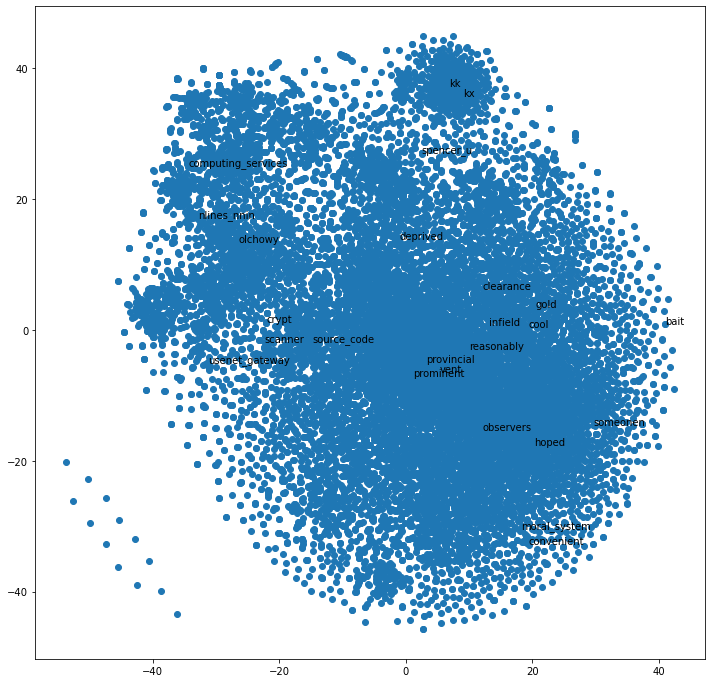

In [67]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(w2v_model)

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly

plot_function(x_vals, y_vals, labels)
plot_with_matplotlib(x_vals, y_vals, labels)

# Storing and loading model

In [69]:
import tempfile

with tempfile.NamedTemporaryFile(prefix='gensim-model-', delete=False) as tmp:
    temporary_filepath = tmp.name
    w2v_model.save(temporary_filepath)
    #
    # The model is now safely stored in the filepath.
    # You can copy it to other machines, share it with others, etc.
    #
    # To load a saved model:
    #
    new_model = Word2Vec.load(temporary_filepath)

2022-05-20 15:27:53,108 : INFO : Word2Vec lifecycle event {'fname_or_handle': '/tmp/gensim-model-b697iwax', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-05-20T15:27:53.108243', 'gensim': '4.2.0', 'python': '3.9.7 (default, Sep 16 2021, 13:09:58) \n[GCC 7.5.0]', 'platform': 'Linux-5.15.32-1-MANJARO-x86_64-with-glibc2.35', 'event': 'saving'}
2022-05-20 15:27:53,109 : INFO : not storing attribute cum_table
2022-05-20 15:27:53,134 : INFO : saved /tmp/gensim-model-b697iwax
2022-05-20 15:27:53,135 : INFO : loading Word2Vec object from /tmp/gensim-model-b697iwax
2022-05-20 15:27:53,149 : INFO : loading wv recursively from /tmp/gensim-model-b697iwax.wv.* with mmap=None
2022-05-20 15:27:53,150 : INFO : setting ignored attribute cum_table to None
2022-05-20 15:27:53,277 : INFO : Word2Vec lifecycle event {'fname': '/tmp/gensim-model-b697iwax', 'datetime': '2022-05-20T15:27:53.277571', 'gensim': '4.2.0', 'python': '3.9.7 (default, Sep 16 2021, 13:09:58) \n[